**1. Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN? And a vector-to-sequence RNN?**

- Sequence-to-Sequence

This is useful for creative RNNs. Give it a melody, and then it will continuously generate more of the melody.

- Sequence-to-Vector

A RNN like this would be useful if you want to input a sequence of arbitrary length and then output some n-dimensional vector. For example, you could take in a movie review or dialogue script of any length, and then output either a -1 to 1 sentiment score or perhaps a larger vector of various emotions (happy, excited, angry, sad, etc.)

- Vector-to-Sequence

This is good for taking your n-dimensional vector (it could even be an image) and outputting an arbitrary-length sequence, for example, autocaptioning of images or videos.

**2. Why do people use encoder-decoder RNNs rather than plain sequence RNNs for automatic translation?**

In translating a sentence, you often need to hear every part of it. Words near the end of a sentence can affect words at the beginning. Thus, it is better to have an encoder-decoder RNN that digests the whole sequence, finds some latent representation of it, and then decodes it into another language from that representation.

**3. How could you combine a convolutional neural network with a RNN to classify videos?**

You could generate features in a smaller space from the convolutional network from each frame of the video, then take **n_step** chunks of data and pass the whole sequence of features per frame of the video into the RNN.

**4. What are the advantages of building an RNN using `dynamic_rnn()` rather than `static_rnn()`?**

This does not apply in Tensorflow v2

**5. How can you deal with variable-length input sequences? What about variable-length output sequences?**

You could pad your instances in each batch so that they all have the same length as the largest instance in that batch.

For variable-length outputs, you can define an "end-of-sequence" character, and any outputs from the RNN after that is ignored.

**6. What is a common way to distribute training and execution of a deep RNN across multiple GPUs?**

This does not apply in Tensorflow v2

**7. Embeddded Reber grammars were used by Hochreiter and Schmidhuber in their paper about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's nice introduction (http://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't.**

In [27]:
import numpy as np

In [28]:
def coinflip():
    return np.random.random() < .5

def p_node():
    val = 'P'
    if coinflip():
        val += 'S'
    else:
        val += t_node()
    return val

def t_node():
    val = ''
    for _ in range(np.random.randint(0,4)):
        val += 'T'
    val += 'V'
    if coinflip():
        val += 'V'
    else:
        val += p_node()
    return val

def gen_reber_string():
    val = 'B'
    if coinflip():
        val += 'T'
        for _ in range(np.random.randint(0,4)):
            val += 'S'
        val += 'X'
        if coinflip():
            val += 'X'
            val += t_node()
        else:
            val+='S'
    else:
        val += 'P'
        val += t_node()
    return val + 'E'

In [29]:
vals = [gen_reber_string() for _ in range(2000)]
print('Mean:',np.mean([len(val) for val in vals]))
print('Std:', np.std([len(val) for val in vals]))
print('First 5:', vals[:5])

Mean: 8.5365
Std: 3.047075278033019
First 5: ['BPTTVVE', 'BPTVVE', 'BTSSSXSE', 'BTSSXXVVE', 'BTSSSXSE']


In [30]:
def gen_non_reber_string():
    val = 'B'
    choices = 'T,P,X,S,V'.split(',')
    num_chars = np.random.randint(3,11)
    for character in np.random.choice(choices, size=num_chars):
        val += character
    return val + 'E'

In [31]:
vals = [gen_non_reber_string() for _ in range(2000)]
print('Mean:',np.mean([len(val) for val in vals]))
print('Std:', np.std([len(val) for val in vals]))
print('First 5:', vals[:5])

Mean: 8.5125
Std: 2.2995312022236187
First 5: ['BSTVPSXTE', 'BXPVTTPXPPXE', 'BVSTE', 'BSSSXPVXVE', 'BVVSPTPTPE']


In [32]:
# Generating data
x, y = [], []
for _ in range(50000):
    if coinflip():
        x.append(gen_reber_string())
        y.append(1)
    else:
        x.append(gen_non_reber_string())
        y.append(0)

In [47]:
char2indx = {u:i for i, u in enumerate('BPSXVTE')}
text_as_int = []
for text in x:
    text_as_int.append(np.array([char2indx[c] for c in text]))
text_as_int = np.array(text_as_int)

In [48]:
def indx_to_char(arr):
    return []

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(text_as_int,y,test_size=.2)
x_train[:5]

array([array([0, 1, 5, 5, 5, 4, 1, 2, 6]),
       array([0, 5, 2, 2, 2, 3, 3, 5, 5, 4, 4, 6]),
       array([0, 1, 4, 5, 6]), array([0, 3, 3, 2, 2, 1, 2, 1, 6]),
       array([0, 5, 3, 4, 3, 5, 2, 4, 3, 6])], dtype=object)

In [53]:
(type(x_train),type(x_test),type(y_train),type(y_test))

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [51]:
y_train = np.asarray(y_train).reshape((-1,1))
y_test = np.asarray(y_test).reshape((-1,1))

In [52]:
y_train.shape

(40000, 1)

In [42]:
import tensorflow as tf

In [56]:
rnn = tf.keras.models.Sequential([
    tf.keras.layers.Input([None,1]),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [57]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
rnn.fit(x_train, y_train, epochs=15)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

**8. Tackle the "How much did it rain? II" Kaggle competition.**

**9. Go through TensorFlow's Word2Vec (http://homl.info/99) tutorial to create word embeddings, and then go through the Seq2Seq (http://homl.info/100) tutorial to train an English-to-French translation system.**

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

"The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the smae way you would experiment with the number of neurons in a Dense layer."

In [4]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [5]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.00825322,  0.02013287, -0.04178565,  0.03150273, -0.04141008],
       [-0.00983317, -0.03650782, -0.02057456,  0.02407458,  0.03882397],
       [-0.00388774, -0.04287608,  0.04303553,  0.04816279,  0.031028  ]],
      dtype=float32)

Note that each of the 3 inputs have a 5-dimensional vector associated with it through the embedding. However, since the Embedding layer is initialized with random weights just like any other layer, there is not any meaning in this embedding yet.

In [7]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                         with_info=True, as_supervised=True)

Shuffling and writing examples to C:\Users\Tim\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteJE02RQ\imdb_reviews-train.tfrecord
Shuffling and writing examples to C:\Users\Tim\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteJE02RQ\imdb_reviews-test.tfrecord
Shuffling and writing examples to C:\Users\Tim\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0.incompleteJE02RQ\imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to C:\Users\Tim\tensorflow_datasets\imdb_reviews\subwords8k\1.0.0. Subsequent calls will reuse this data.


In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [10]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10) # Using padded batches fixes the issue of having variable lengths
# on our reviews

In [11]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[6179,  979, 3029, ...,    0,    0,    0],
       [ 392, 8002, 7968, ...,    0,    0,    0],
       [ 173,   29,   63, ...,    0,    0,    0],
       ...,
       [  62,   27,  205, ...,    0,    0,    0],
       [  19,  751, 1237, ...,    0,    0,    0],
       [  12,  258,  305, ...,    0,    0,    0]], dtype=int64)

In [16]:
encoder.decode(train_batch[1][:50])

"So I'm at home, flipping channels one night, and I come across this man wearing heels and makeup, standing in front of a colored background on HBO. Naturally, I did a double-take and "

In [18]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [19]:
history = model.fit(train_batches, epochs=10, validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.6718 - accuracy: 0.5755 - val_loss: 0.6186 - val_accuracy: 0.7500
Epoch 2/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5802 - accuracy: 0.8533 - val_loss: 0.5809 - val_accuracy: 0.8500
Epoch 3/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5564 - accuracy: 0.8949 - val_loss: 0.5873 - val_accuracy: 0.8500
Epoch 4/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.5458 - accuracy: 0.9154 - val_loss: 0.5564 - val_accuracy: 0.8650
Epoch 5/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5395 - accuracy: 0.9273 - val_loss: 0.5512 - val_accuracy: 0.8600
Epoch 6/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5348 - accuracy: 0.9365 - val_loss: 0.5850 - val_accuracy: 0.8400
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5317 - accuracy: 0.9420 - val_loss: 0.5731 - val_accur

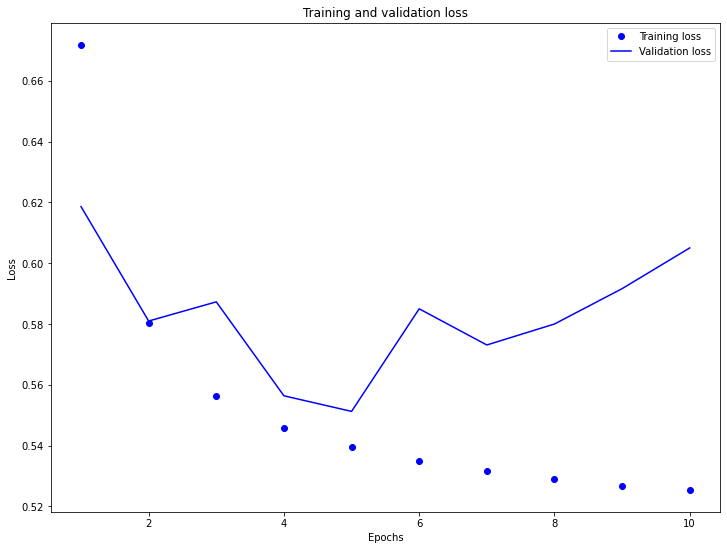

In [21]:
import matplotlib.pyplot as plt
history_dict = history.history

acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']
loss, val_loss = history_dict['loss'], history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

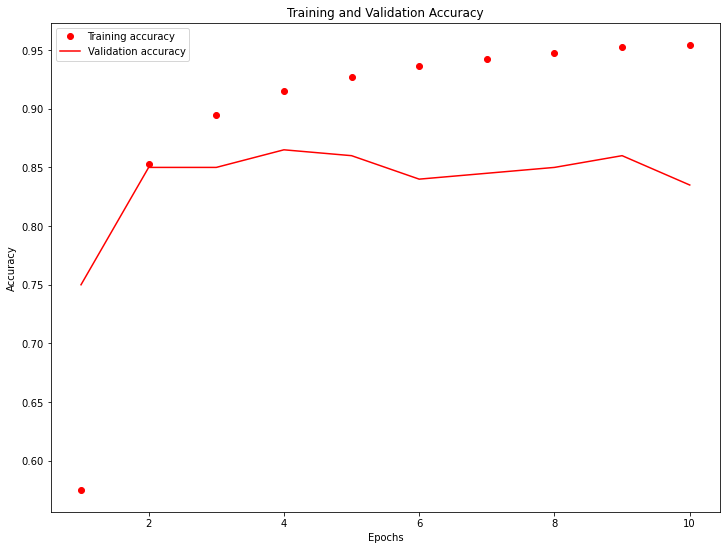

In [22]:
plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
embedding = model.layers[0]
weights = embedding.get_weights()[0]
weights.shape

(8185, 16)

In [24]:
import io

In [25]:
encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv','w', encoding='utf-8')
out_m = io.open('meta.tsv','w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in vec]) + '\n')
out_v.close()
out_m.close()